In [8]:
from ode_composer.statespace_model import StateSpaceModel
from scipy.integrate import solve_ivp
from ode_composer.dictionary_builder import DictionaryBuilder
from ode_composer.sbl import SBL
from ode_composer.measurements_generator import MeasurementsGenerator
import matplotlib.pyplot as plt
import numpy as np
import time
from ode_composer.signal_preprocessor import (
    GPSignalPreprocessor,
    RHSEvalSignalPreprocessor,
    SplineSignalPreprocessor,
)

# Intro 
In this sample we use a [Lota-Volterra](https://en.wikipedia.org/wiki/Lotka–Volterra_equations) model. We will show how to generate the State Space model, generate measurements using the MeasumrenetsGenerator and finally show the workflow for preprocessing the singals and generating the analytical results.

In [24]:
# Define the Lotka-Volterra model and generate the StateSpaceModel object
states = {"x1": "alpha*x1-beta*x1*x2", "x2": "delta*x1*x2-gamma*x2"} # Lotka-Volterra model - the entries on this model will be parsed and converted to sympy expressions
parameters = {"alpha": 2 / 3, "beta": 4 / 3, "delta": 2, "gamma": 1} # Parameters can be defined as well allowing for the model to be defined in a more compact way
ss = StateSpaceModel.from_string(states=states, parameters=parameters) # Generate the StateSpaceModel object
print("Original Model:")
print(ss)


Original Model:
dx1/dt = +1.00e+00*-1.33333333333333*x1*x2 + 0.666666666666667*x1
dx2/dt = +1.00e+00*2*x1*x2 - x2



The model we will try to estimate now is: $\frac{dx_1}{dt} = \frac{4}{3}x_1 x_2 + \frac{2}{3}x_1$ and $\frac{dx_2}{dt} = 2x_1 x_2 - x_2$

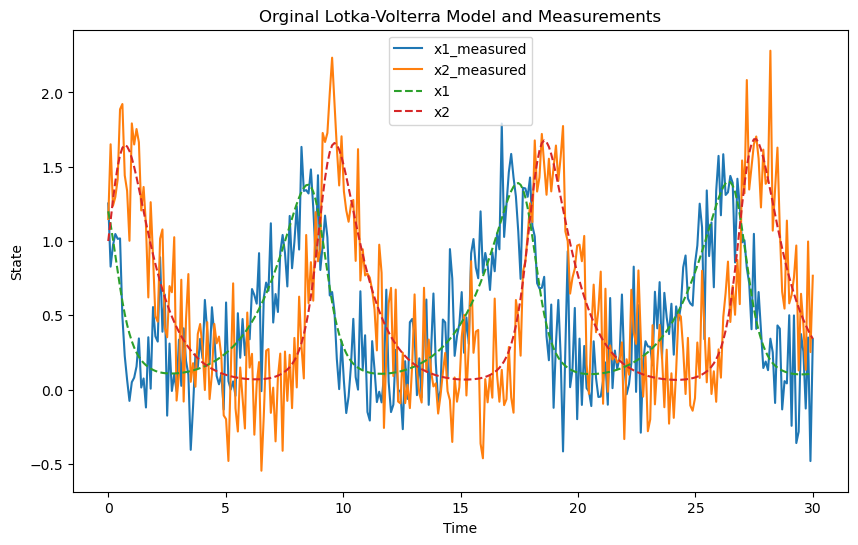

In [75]:
# Define the time span for the simulation and the initial conditions
t_span = [0, 30] # Time span for the simulation
x0 = {"x1": 1.2, "x2": 1.0} # Initial conditions for the simulation
data_points = 300 # Number of data points to simulate
SNR = 8 # Signal to noise ratio for the simulated data - will be fed to the MeasurementsGenerator 

# Generate the measurements
gm = MeasurementsGenerator(
    ss=ss, time_span=t_span, initial_values=x0, data_points=data_points
)
t, y = gm.get_measurements(SNR_db=SNR)

# get the noiseless measurements
t_orig, y_orig = gm.get_measurements()

# Plot the measurements (no noise)
plt.figure(figsize=(10, 6))
plt.plot(t, y.T, label=["x1_measured", "x2_measured"])
plt.plot(t_orig, y_orig.T, "--", label=["x1", "x2"])
plt.xlabel("Time")
plt.ylabel("State")
plt.title("Orginal Lotka-Volterra Model and Measurements")
plt.legend()
plt.show()


## Singal preprocessing
As mentioned, the package also provides the ability to Preprocess the signal. The SBL algorithm will adjust the sparsity penalty based on the noise of the signal. We can use Gaussian Processes to estimate the noise of a signal after optimising a Kernel over our data. Additionally, GP's mean can provide a great starting point for calculating the time derivative of noisiy singals. 

In [79]:
# Preprocess the data using the GPSignalPreprocessor and the RBF kernel
start_time = time.time()
gproc = GPSignalPreprocessor(t=t, y=y[0, :], selected_kernel="RBF")
y_samples_1, t_gp = gproc.interpolate(return_extended_time=False, noisy_obs=True)
gproc.calculate_time_derivative()
dydt_1 = gproc.dydt
dydt_1_std = gproc.A_std

# Preprocess the second set of data using the GPSignalPreprocessor and the RBF kernel
gproc_2 = GPSignalPreprocessor(t=t, y=y[1, :], selected_kernel="RBF")
y_samples_2, _ = gproc_2.interpolate(noisy_obs=True)
gproc_2.calculate_time_derivative()
dydt_2 = gproc_2.dydt
dydt_2_std = gproc_2.A_std

print("Time for the estimation of the derivatives through GPs:")
print(time.time() - start_time)

Time for the estimation of the derivatives through GPs:
0.44411396980285645


In [80]:
# You can also find out which are the possible kernels to use
print("Available kernels:")
print(gproc.get_avaialble_kernels())

Available kernels:
dict_keys(['RBF', 'RatQuad', 'ExpSineSquared', 'Matern', 'Matern*ExpSineSquared', 'RBF*ExpSineSquared', 'RatQuad*ExpSineSquared', 'Matern*RBF', 'Matern+ExpSineSquared', 'RBF+ExpSineSquared', 'RatQuad+ExpSineSquared'])


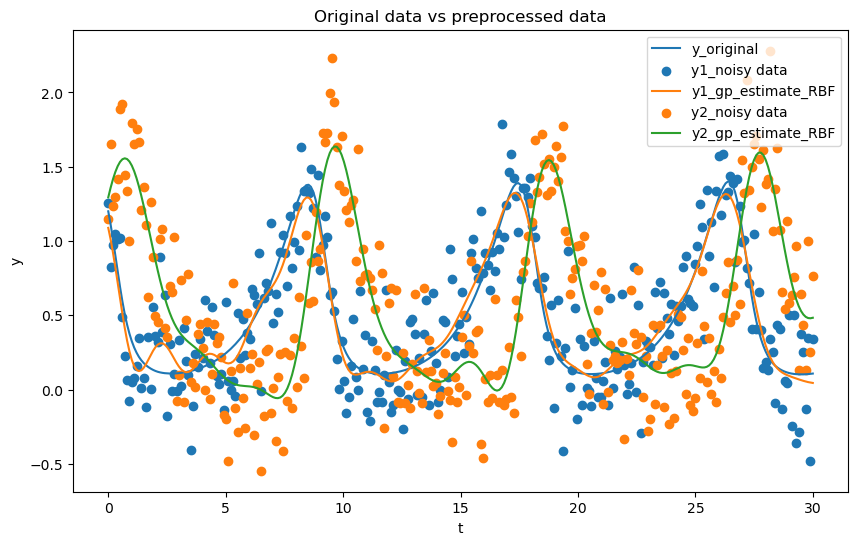

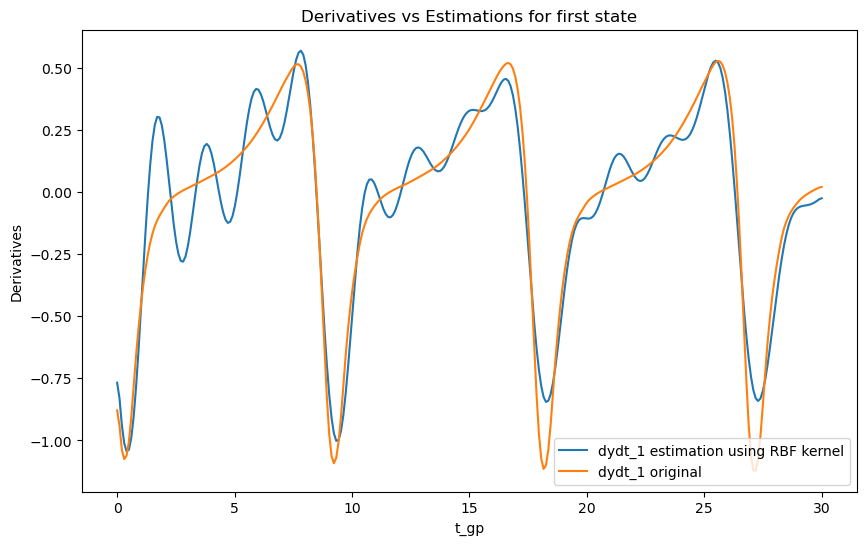

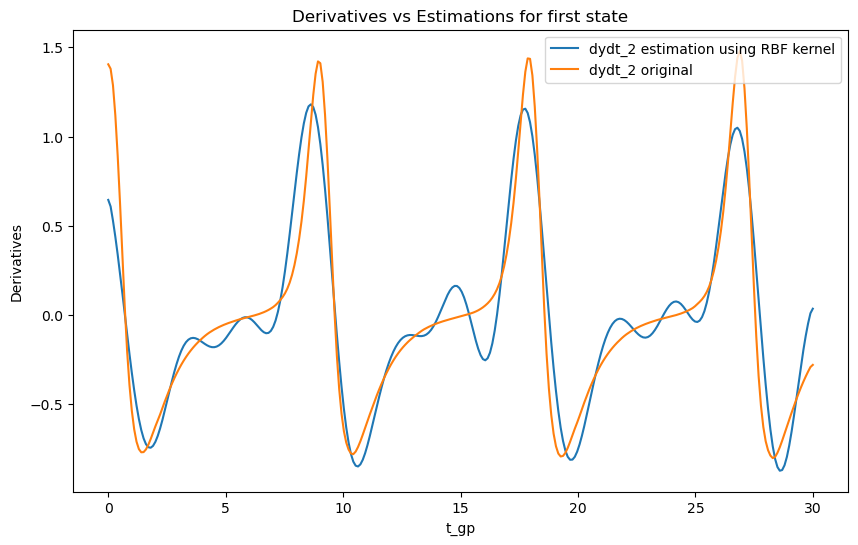

In [86]:
import matplotlib.pyplot as plt

# get the noiseless measurements
t_orig, y_orig = gm.get_measurements()

# Calculate the noiseless derivatives numerically
dydt_orig1 = np.zeros_like(y_orig)
dydt_orig1[0, :] = np.gradient(y_orig[0, :], t_orig)
dydt_orig_2 = np.zeros_like(y_orig)
dydt_orig_2[0, :] = np.gradient(y_orig[1, :], t_orig)


# Plot the original data (y and t are the original data, y_samples and t_gp are the preprocessed data)
plt.figure(figsize=(10, 6))
plt.plot(t_orig, y_orig[0, :], label='y_original')
plt.scatter(t, y[0, :], label='y1_noisy data')
plt.plot(t_gp, y_samples_1, label='y1_gp_estimate_RBF')
plt.scatter(t, y[1, :], label='y2_noisy data')
plt.plot(t_gp, y_samples_2, label='y2_gp_estimate_RBF')
plt.xlabel('t')
plt.ylabel('y')
plt.legend()
plt.title('Original data vs preprocessed data')


# Plot derivatives and their estimations
plt.figure(figsize=(10, 6))
plt.plot(t_gp, dydt_1, label='dydt_1 estimation using RBF kernel')
plt.plot(t_orig, dydt_orig1[0, :], label='dydt_1 original')
plt.xlabel('t_gp')
plt.ylabel('Derivatives')
plt.legend()
plt.title('Derivatives vs Estimations for first state')

# Plot derivatives and their estimations for the second state
plt.figure(figsize=(10, 6))
plt.plot(t_gp, dydt_2, label='dydt_2 estimation using RBF kernel')
plt.plot(t_orig, dydt_orig_2[0, :], label='dydt_2 original')
plt.xlabel('t_gp')
plt.ylabel('Derivatives')
plt.legend()
plt.title('Derivatives vs Estimations for first state')

plt.show()


## Observations
As we can see the choice of kernel can 

In [87]:
spline_1 = SplineSignalPreprocessor(t, y[0,:])
x_spline = spline_1.interpolate(t)
dx_spline = spline_1.calculate_time_derivative(t)

spline_2 = SplineSignalPreprocessor(t, y[1,:])
y_spline = spline_2.interpolate(t)
dy_spline = spline_2.calculate_time_derivative(t)


rhs_preprop = RHSEvalSignalPreprocessor(
    t=t, y=y, rhs_function=ss.get_rhs, states=states
)

In [94]:
# step 1 define a dictionary
d_f = ["x1", "x1*x2", "x2", "x1/x2", "x1**2/x2", "x2**2/x1", "1"]
dict_builder = DictionaryBuilder(dict_fcns=d_f)
dict_functions = dict_builder.dict_fcns
# associate variables with data
data = {"x1": y_samples_1.T, "x2": y_samples_2.T}


A = dict_builder.evaluate_dict(input_data=data)


start_time = time.time()

# step 2 define an SBL problem
# with the Lin reg model and solve it
lambda_param_1 = 1 
sbl_x1 = SBL(
    dict_mtx=A,
    data_vec=dydt_1,
    lambda_param=lambda_param_1,
    state_name="x1",
    dict_fcns=dict_functions,
)
sbl_x1.compute_model_structure()

lambda_param_2 = 1
print(lambda_param_2)
sbl_x2 = SBL(
    dict_mtx=A,
    data_vec=dydt_2,
    lambda_param=lambda_param_2,
    state_name="x2",
    dict_fcns=dict_functions,
)
sbl_x2.compute_model_structure()

print("Time for the structure estimation:")
print(time.time()-start_time)

# step 4 reporting
# #build the ODE
zero_th = 1e-5

ode_model = StateSpaceModel.from_sbl(
    {
        "x1": sbl_x1.get_results(zero_th=zero_th),
        "x2": sbl_x2.get_results(zero_th=zero_th),
    },
    parameters=None,
)
print("Estimated ODE model:")
print(ode_model)

1
Time for the structure estimation:
0.2350001335144043
Estimated ODE model:
dx1/dt = +4.63e-01*x1-1.01e+00*x1*x2
dx2/dt = +1.54e+00*x1*x2-7.59e-01*x2



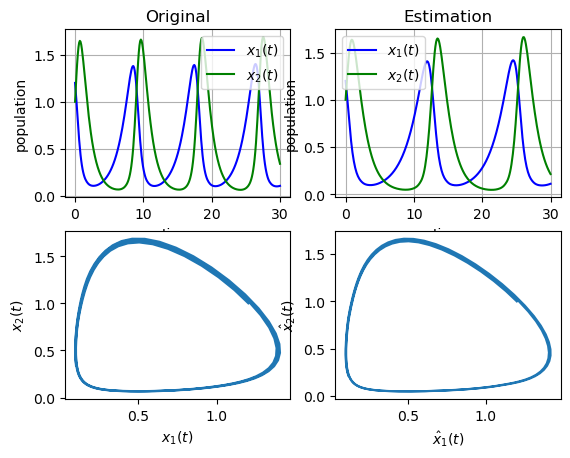

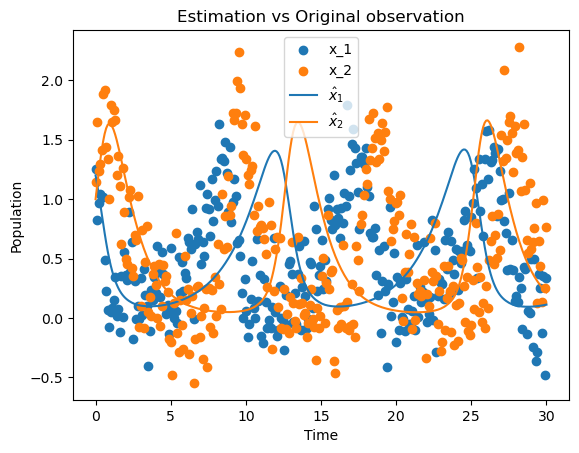

In [95]:

states = ["x1", "x2"]
y0 = [1.2, 1]
sol_ode = solve_ivp(fun=ode_model.get_rhs, t_span=t_span, t_eval=t_gp, y0=y0, args=(states,))
# report
plt.subplot(221)
t_orig, y_orig = gm.get_measurements()
plt.plot(t_orig, y_orig[0, :], "b", label=r"$x_1(t)$")
plt.plot(t_orig, y_orig[1, :], "g", label=r"$x_2(t)$")
plt.legend(loc="best")
plt.xlabel("time")
plt.ylabel("population")
plt.title("Original")
plt.grid()
plt.subplot(222)
plt.plot(sol_ode.t, sol_ode.y[0, :], "b", label=r"$x_1(t)$")
plt.plot(sol_ode.t, sol_ode.y[1, :], "g", label=r"$x_2(t)$")
plt.legend(loc="best")
plt.xlabel("time")
plt.ylabel("population")
plt.title("Estimation")
plt.grid()
plt.subplot(223)
plt.plot(y_orig[0, :], y_orig[1, :])
plt.xlabel(r"$x_1(t)$")
plt.ylabel(r"$x_2(t)$")
plt.subplot(224)
plt.plot(sol_ode.y[0, :], sol_ode.y[1, :])
plt.xlabel(r"$\hat{x}_1(t)$")
plt.ylabel(r"$\hat{x}_2(t)$")
plt.show()

plt.figure()
plt.scatter(t, y[0,:], label=r"x_1")
plt.scatter(t, y[1,:], label=r"x_2")
plt.plot(sol_ode.t, sol_ode.y[0,:], '-', label=r"$\hat{x}_{1}$")
plt.plot(sol_ode.t, sol_ode.y[1,:], '-', label=r"$\hat{x}_{2}$")
plt.legend()
plt.title("Estimation vs Original observation")
plt.xlabel('Time')
plt.ylabel('Population')
plt.show()

# Conclusion
As we can see, the SBL algorithm can be an optiomal way of estimating the parameters of a model. The package provides a simple way of generating the State Space model, generating measurements and preprocessing the signals.